# UCLAIS Tutorial Series Challenge 2

We are proud to present you with the second challenge of the 2022-23 UCLAIS tutorial series: the CIFAR-10 image classification problem. You will be introduced to a variety of core concepts in **computer vision** and specifically the implementation of convolutional neural network (CNN) architectures using the popular machine learning package, [TensorFlow](https://www.tensorflow.org/).

This Jupyter notebook will guide you through the various general stages involved in end-to-end machine learning projects, including data visualisation, data preprocessing, model selection, model training and model evaluation. Finally, you will have the opportunity to submit the model you build to [DOXA](https://doxaai.com/) for evaluation on an unseen test set.

If you do not already have a DOXA account, you will want to [sign up](https://doxaai.com/sign-up) first before proceeding.

## Background & Motivation

**CIFAR 10**

![title](./media/CIFAR-10.png)

**Background**: Image classification is one of the fundamental tasks in the domain of computer vision. It has revolutionised and propelled technological advancements in many prominent fields and industries, including healthcare, manufacturing, the automobile industry and much more.

**Objective**: For this challenge, your aim is to build a model that can accurately predict the class to which images drawn from the popular CIFAR-10 dataset belong. The images in the dataset can each belong to one of ten different classes.

**Dataset**: The dataset is based on the following [CIFAR-10 dataset](hhttps://www.cs.toronto.edu/~kriz/cifar.html). We have divided the dataset into a **'smaller dataset'** (43.9 MB), as well as a **'larger dataset'** (146.5 MB) you can use if you are feeling more comfortable. The small dataset contains 15,000 images, where each class has 1,500 images, whereas the large dataset contains 50,000 images in total, where each class has 5,000 images. In other words, these datasets are _balanced_. The partitioned dataset can be downloaded from [Google Drive](https://drive.google.com/drive/folders/11M8y08hEDTmMpVq3tZCU9ajX7Gui_0nN).

## Installing and Importing Useful Packages

To get started, we will install a number of common machine learning packages.

In [1]:
%pip install numpy pandas matplotlib seaborn scikit-learn doxa-cli gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import relevant libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

# Import relevant sklearn classes/functions related to data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Import relevant TensorFlow classes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam

%matplotlib inline

## Data Loading
The first step is to gather the data that we will be using. The data can be downloaded directly via [Google Drive](https://drive.google.com/drive/folders/11M8y08hEDTmMpVq3tZCU9ajX7Gui_0nN) or just by simply running the cell below. 

In [3]:
# Let's download the dataset if we don't already have it!
if not os.path.exists("data"):
    os.makedirs("data", exist_ok=True)

    !gdown https://drive.google.com/drive/folders/11M8y08hEDTmMpVq3tZCU9ajX7Gui_0nN -O ./data --folder

We will be using the small dataset in this notebook, but feel absolutely free to switch to the large dataset if you are feeling comfortable. To do so, just comment out the lines that load the features and labels for the small dataset, and then uncomment those corresponding to the large dataset. It will allow you to improve your model further, but you may require additional compute power.

In [4]:
# Select either the "small" dataset or the "large" dataset
DATASET = "small"
# DATASET = "large"

# Load the saved .npz file
data_original = np.load(f"./data/train_{DATASET}.npz")["data"]

# Load the labels
labels = np.genfromtxt(f"./data/train_{DATASET}_label.csv").astype("uint8")

In [5]:
# We then make an in-memory copy of the dataset that we can manipulate 
# and experiment with. Just remember to rerun this code block when you
# change your data preprocessing approach!

data = data_original.copy()

## Data Understanding & Visualisation
Before we start to train our model, it is important to have a look and first understand the dataset that we will be using. This will provide some insight as to which which model architectures, model hyperparameter values and loss functions might be suitable for the problem we are trying to solve. 

In [6]:
# Let's have a look at the shape of our training and testing set
print(f"Shape of the dataset: {data.shape}")
print(f"Shape of the labels: {labels.shape}")

Shape of the dataset: (15000, 32, 32, 3)
Shape of the labels: (15000,)


In [7]:
labels

array([9, 2, 5, ..., 7, 4, 4], dtype=uint8)

In [8]:
# Print the labels
label_names = open("./data/label.txt").read().splitlines()

print(label_names)

['cat', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile']


Next, let's have a look at a subset of the images.

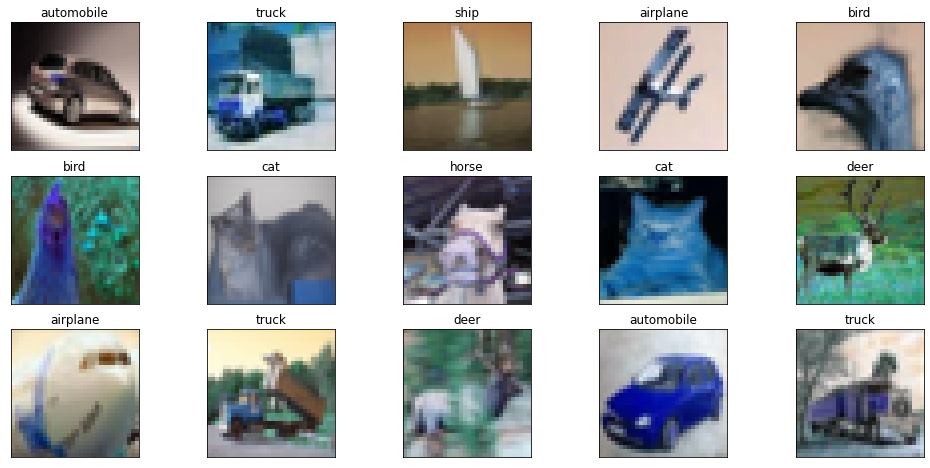

In [9]:
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(17, 8))
index = 0
for i in range(3):
    for j in range(5):
        axes[i, j].set_title(label_names[labels[index]])
        axes[i, j].imshow(data[index])
        axes[i, j].get_xaxis().set_visible(False)
        axes[i, j].get_yaxis().set_visible(False)
        index += 1
        
plt.show()

From the simple code we have executed above, there are several things we can observe:

- Our dataset is composed of 15000 images
- The size of each image is 32x32 and composed of three channels (red, green and blue)
- The output is an integer in the range of 0 to 9, each corresponding to a class
- We are dealing with multi-class classification problem!

## Label Preprocessing

As shown in the previous section, each label is an integer in the range of 0 to 9. This is not really suitable for our neural network, so we will instead one-hot encode the labels using the [LabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) class provided by Scikit-Learn.

In [10]:
label_encoder = LabelBinarizer()
label_encoder.fit(labels.reshape(-1, 1))

LabelBinarizer()

In [11]:
encoded_labels = label_encoder.transform(labels.reshape(-1, 1))

encoded_labels

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Neat! Now, our labels have been one-hot encoded. 

## Splitting the Training and Validation Set

The next preprocessing step that need to be done before we can proceed to the training step is to split our dataset into the training set and validation set. The training set will be used for the training of our model while the validation set will be used to compare the performance of different models.


In [12]:
# Split our features and output labels into a training set and a validation set
X_train, X_valid, y_train, y_valid = train_test_split(
    data, encoded_labels, test_size=0.2
)

# In this case, the test_size parameter is equal to 0.2, so that our validation set will
# have 20% of the data, while the training set will have the remaining 80% of the data

## Constructing CNN

Now that we have done all of the required preprocessing steps, we can proceed to the most exciting stage, which is constructing the neural network. For this, we will build a convolutional neural network, which is a popular neural network architecture in the domain of computer vision. 

In [13]:
# Display the shape of the training set
print(f"Shape of training set: {X_train.shape}")

# Set a variable to store the shape of the image as it will be used later
input_shape = X_train[0].shape
print(f"Shape of each input image: {input_shape}")

Shape of training set: (12000, 32, 32, 3)
Shape of each input image: (32, 32, 3)


To construct the convolutional neural network, we will be using the functionality provided by TensorFlow, which greatly simplifies the task of building neural networks. The [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers) describes all the building blocks we can use to construct neural network models in detail.

In [14]:
model = Sequential(
    [
        Conv2D(
            filters=16,
            kernel_size=(3, 3),
            activation="relu",
            padding="same",
            input_shape=input_shape,
        ),
        Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
        Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(units=128, activation="relu"),
        Dropout(rate=0.5),
        Dense(units=64, activation="relu"),
        Dense(units=10, activation="softmax"),
    ]
)

That's it! With a few lines of code, we are able to create a convolutional neural network. There are only two important rules that you need to follow:

- The first NN block must have the `input_shape` argument that specifies the size of the input images
- The final NN block must output the right shape for the classes we are trying to predict

Other than that, you can be creative on how you want to engineer your architecture! Visit [TensorFlow Keras Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) for further information on what other neural network building blocks you have available to you.

In [15]:
# Let's have a look at a summary of the model we have created
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 128)               2097280   
                                                        

There is a total parameter count of ~2,000,000 for this architecture; hence, around ~2,000,000 weights and biases are being optimised for this problem in training. As you can imagine, the larger and more complex your architecture is, the higher the number of parameters that need to be trained, so it will require a large computation power. It is therefore important to be careful not to make your model absolutely massive!

Shown below is the illustration of the CNN architecture we have just created. You can go to this [cool website](http://alexlenail.me/NN-SVG/index.html), where you can visualise the neural network by inputting the architecture of your neural network.

![CNN Architecture](./media/CNNArchitecture.png)

## Training the Model

This is where the magic happens. We will start training our training set with the neural network architecture that we have created before.



In [16]:
# Set all the required hyperparameters before starting the training process
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Start the training and save its progress in a variable called 'history'
history = model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), epochs=10)

Epoch 1/10
375/375 [==============================] - 21s 56ms/step - loss: 3.1700 - accuracy: 0.1293 - val_loss: 2.0817 - val_accuracy: 0.2250
Epoch 2/10
375/375 [==============================] - 36s 97ms/step - loss: 2.0366 - accuracy: 0.2399 - val_loss: 1.7448 - val_accuracy: 0.3557
Epoch 3/10
375/375 [==============================] - 30s 81ms/step - loss: 1.7984 - accuracy: 0.3292 - val_loss: 1.5995 - val_accuracy: 0.4243
Epoch 4/10
375/375 [==============================] - 25s 65ms/step - loss: 1.6331 - accuracy: 0.3991 - val_loss: 1.4886 - val_accuracy: 0.4613
Epoch 5/10
375/375 [==============================] - 24s 63ms/step - loss: 1.5176 - accuracy: 0.4477 - val_loss: 1.4262 - val_accuracy: 0.4853
Epoch 6/10
375/375 [==============================] - 28s 75ms/step - loss: 1.3792 - accuracy: 0.4958 - val_loss: 1.5086 - val_accuracy: 0.4857
Epoch 7/10
375/375 [==============================] - 27s 71ms/step - loss: 1.2612 - accuracy: 0.5454 - val_loss: 1.3740 - val_accuracy:

You may realise that it take a bit of a time to train the model (especially if you are training on a CPU, rather than a GPU) since we are training approximately ~2,000,000 parameters. If you do not have any access to more powerful compute locally, you can use the free GPU service in Google Colab by changing its runtime type. 

To change the runtime type in Google Colab, perform the following instructions:
1. Go to the Toolbar located at the top, and click 'Runtime'
2. Click the 'Change runtime type' section
3. A window will pop up and you can select either to use a GPU or a TPU as your hardware accelerator

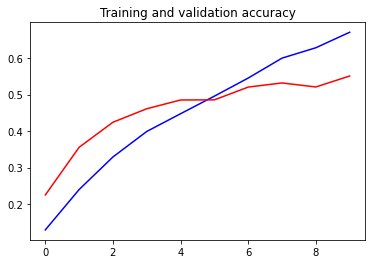

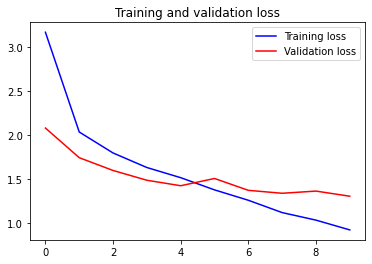

In [17]:
# Now that we have trained our model, let's plot how our model performed
# on both the training and validation dataset as the number of iteration increases
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(accuracy))

plt.figure(1)
plt.plot(epochs, accuracy, "b", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend
plt.show()

plt.figure(2)
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

From the observation above, our neural network seems to have trained properly, since the validation loss keeps getting smaller and smaller in tandem with the training loss.

## Analyse the Model

Let's proceed to analyse our model further. The hope is that we might be able to capture some insight that can be used to create a better CNN architecture.

In [18]:
# Let's run our model on the validation set and base our class predictions on
# whichever neuron (of the 10 neurons in the output layer) has the largest value

prediction = model.predict(X_valid)
y_pred = np.argmax(prediction, axis=1)

# Do the same thing for our true labels
y_true = np.argmax(y_valid, axis=1)

94/94 [==============================] - 2s 15ms/step


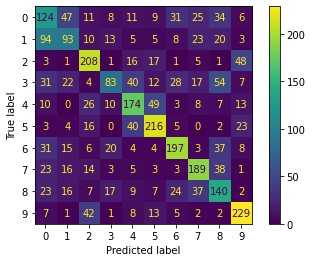

In [19]:
print(ConfusionMatrixDisplay.from_predictions(y_true=y_true, y_pred=y_pred))

## Preparing our DOXA Submission

Once we are content with the performance of our model, we can submit the model to DOXA for evaluation on an unseen test set! 

In [ ]:
# Create a submission folder by downloading it 'curling' it from Github
if not os.path.exists("submission"):
    os.makedirs("submission")
    
    !curl https://raw.githubusercontent.com/UCLAIS/doxa-challenges/main/Challenge-2/submission/doxa.yaml --output submission/doxa.yaml
    !curl https://raw.githubusercontent.com/UCLAIS/doxa-challenges/main/Challenge-2/submission/run.py --output submission/run.py

In [ ]:
# Save the CNN model in the submission folder
model.save("submission/model")

## Submitting to DOXA

Before you can submit to DOXA, you must first ensure that you are enrolled for the challenge on the DOXA website. Visit [the challenge page](https://doxaai.com/competition/uclais-2) and click "Enrol" in the top-right corner.

You can then log in using the DOXA CLI by running the following command:

In [ ]:
!doxa login

You can then submit your results to DOXA by running the following command:

In [ ]:
!doxa upload submission

Yay! You have (probably) just uploaded your model to DOXA! Let's give DOXA some time for it to evaluate the performance of your model. You will then be able to see how your model performs on the [scoreboard](https://doxaai.com/competition/uclais-2)!

## Possible Improvements

The performance of our model on the validation set is approximately 55%, so, there is definitely scope for improvement! Here are a some ways we could improve the process:

**1. Image Preprocessing**
- Maybe we could standardise the image data, do some thresholding, or even change the colour space of our dataset as an additional image preprocessing step; however, it can be a little bit tricky, since every image in our dataset is very different from one another, such as in medical imaging datasets, wherein each image looks fairly similar to each other, which we can take advantage of.

**2. Better Architecture**
- The architecture that we have built is a very simple architecture. We can definitely improve our model by building a deeper architecture (which is why some neural netowrks are called deep neural networks 😎). Take a look at the famous [VGG-16](https://www.kaggle.com/code/blurredmachine/vggnet-16-architecture-a-complete-guide/notebook) and [LeNet-5](https://www.kaggle.com/code/blurredmachine/lenet-architecture-a-complete-guide/notebook) architectures for inspiration, and see what you can build based on what you learn.

**3. Larger Training Set**
- In this solution, we are only using the small dataset, but changing to a larger dataset could very likely improve the performance of our model.
- On top of that, we can expand our training set by performing data augmentation. Refer to this [website](https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/) for further information on this topic.

And perhaps, many more...